# Итоговый проект, "Телеком"

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.
#### Описание услуг
Оператор предоставляет два основных типа услуг: 
 - **Стационарную телефонную связь**. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
 
 - **Интернет**. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:

 - Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
 - Выделенная линия технической поддержки (TechSupport);
 - Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
 - Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

Цель работы - обучить модель, которая будет предсказывать возможность ухода клиента из компании. Модель должна показывать результат AUC-ROC выше 0.85.

## Предварительный анализ данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import phik
from phik import resources, report
from phik.report import plot_correlation_matrix

from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, 
                             roc_auc_score, 
                             roc_curve,
                             confusion_matrix
)    
from sklearn.model_selection import (GridSearchCV, 
                                     RandomizedSearchCV,
                                     train_test_split
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OneHotEncoder,
                                   StandardScaler
)
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 100723

In [2]:
#Загрузим данные
contract = pd.read_csv('/datasets/contract_new.csv')
internet = pd.read_csv('/datasets/internet_new.csv')
personal = pd.read_csv('/datasets/personal_new.csv')
phone = pd.read_csv('/datasets/phone_new.csv')

In [3]:
files = ['/datasets/contract_new.csv', '/datasets/internet_new.csv', '/datasets/personal_new.csv', '/datasets/phone_new.csv']
dataframes = {}

for file_name in files:
    df_name = file_name.split('.')[0]  
    df_name = df_name.replace('new', '') 
    df_name = df_name.replace('/datasets/', '') 
    dataframes[df_name] = pd.read_csv(file_name)

for df_name, df in dataframes.items():
    print(f"--- {df_name} ---")
    print(df.head())
    print()

In [4]:
for df_name, df in dataframes.items():
    print(f"--- {df_name} ---")
    print(df.info())
    print()

Всего в данных 7043 пользователя, но в датасетах internet и phone меньше данных (5517 и 6361), потому что не все пользователи подключили дополнительные услуги или и интернет, и телефонную связь. Следовательно, затем при объединении датасетов образуются пропуски.

In [5]:
for df_name, df in dataframes.items():
    print(f"--- {df_name} ---")
    print(df.describe())
    print()

In [6]:
#Изменим тип столбца TotalCharges на float
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

In [7]:
contract[contract['TotalCharges'].isna()]

In [8]:
contract['TotalCharges'] = contract['TotalCharges'].fillna(0)
contract['TotalCharges'].isna().sum()

In [9]:
#Изменим тип столбца BeginDate на datetime
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')

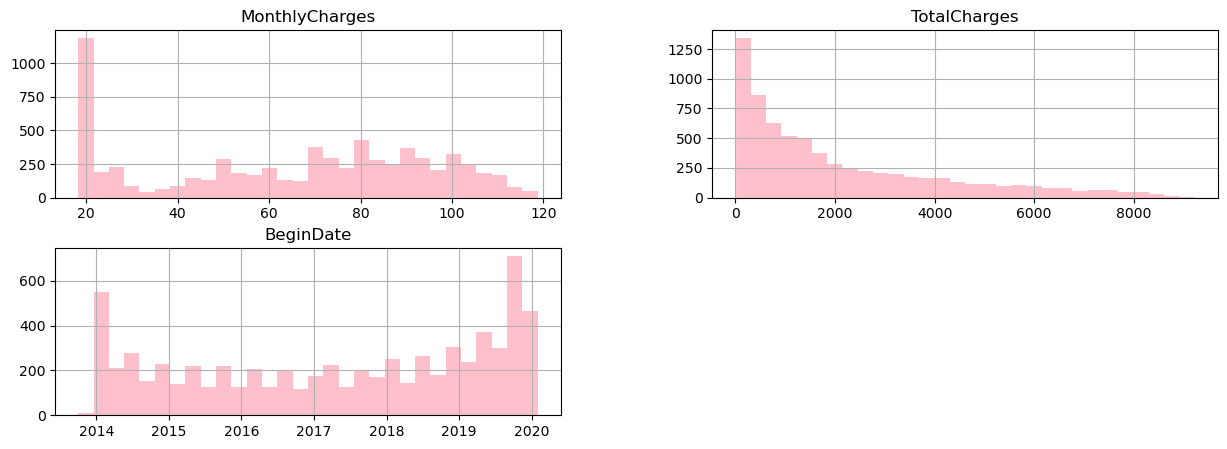

In [10]:
#Посмотрим на распределение признаков
contract[['MonthlyCharges', 'TotalCharges', 'BeginDate']].hist(color='pink', figsize=(15, 5), bins=30);

In [11]:
#Проверим наличие дубликатов в данных
for df_name, df in dataframes.items():
    print(f"--- {df_name} ---")
    print(f'Количества дубликатов в {df_name}: {df.duplicated().sum()}')
    print()

In [12]:
#Проверим наличие пропусков в данных
for df_name, df in dataframes.items():
    print(f"--- {df_name} ---")
    print(f'Количества пропусков в {df_name}: {df.isna().sum()}')
    print()

In [13]:
#Заменим названия так, чтобы они все начинались с большой буквы
contract = contract.rename(columns={'customerID':'CustomerID'})
internet = internet.rename(columns={'customerID':'CustomerID'})
personal = personal.rename(columns={'gender':'Gender', 'customerID':'CustomerID'})
phone = phone.rename(columns={'customerID':'CustomerID'})

In [14]:
datasets = [contract, internet, personal, phone]
for x in datasets:
    print(x.columns.values)

In [15]:
#Объеденим таблицы
data = contract.merge(internet, how='left', on='CustomerID')\
               .merge(personal, how='left', on='CustomerID')\
               .merge(phone, how='left', on='CustomerID')

In [16]:
data.info()

In [17]:
data['CustomerID'].is_unique

In [18]:
#Сделаем CustomerID индексом
data = data.set_index('CustomerID')

In [19]:
data.head()

In [20]:
data.isna().sum()

После объединения образовались пропуски в столбцах датасета internet и phone. Скорее всего, это пользователи, которые не подключили услуги.

In [21]:
#Проверим, находятся ли все 1526 пропусков у одних и тех же пользователей
data[data['InternetService'].isna() & 
     data['OnlineSecurity'].isna() & 
     data['OnlineBackup'].isna() & 
     data['InternetService'].isna() &
     data['DeviceProtection'].isna() &
     data['TechSupport'].isna() &
     data['StreamingTV'].isna() &
     data['StreamingMovies'].isna() ]

Все пропуски у одних и тех же людей, так что заменим пропуски на No.

In [22]:
for column in ('InternetService',
               'OnlineSecurity',  
               'DeviceProtection', 
               'TechSupport', 
               'StreamingTV', 
               'StreamingMovies', 
               'OnlineBackup',
               'MultipleLines'):
    data[column] = data[column].fillna('No') 

In [23]:
data.isna().sum()

In [24]:
data.head(10)

Создадим несколько новых признаков: 

 - Left: если пользователь ушёл, то 1, если остаётся, то 0
 - Total Days: сколько всего дней человек является или являлся пользователем компании

In [25]:
data['Left'] = (data['EndDate'] != 'No').astype(int)

In [26]:
#Заменим No в EndDate на дату выгрузки датасета (2020-02-01)
data['EndDate'] = data['EndDate'].replace(['No'], ['2020-02-01'])
data['EndDate'] = pd.to_datetime(data['EndDate'], format='%Y-%m-%d')

In [27]:
data['TotalDays'] = (data['EndDate'] - data['BeginDate']).dt.days

In [28]:
#Уберём столбцы BeginDate и EndDate
data = data.drop(['BeginDate', 'EndDate'], axis=1)

In [29]:
data.head()

In [30]:
data.info()

### Анализ данных

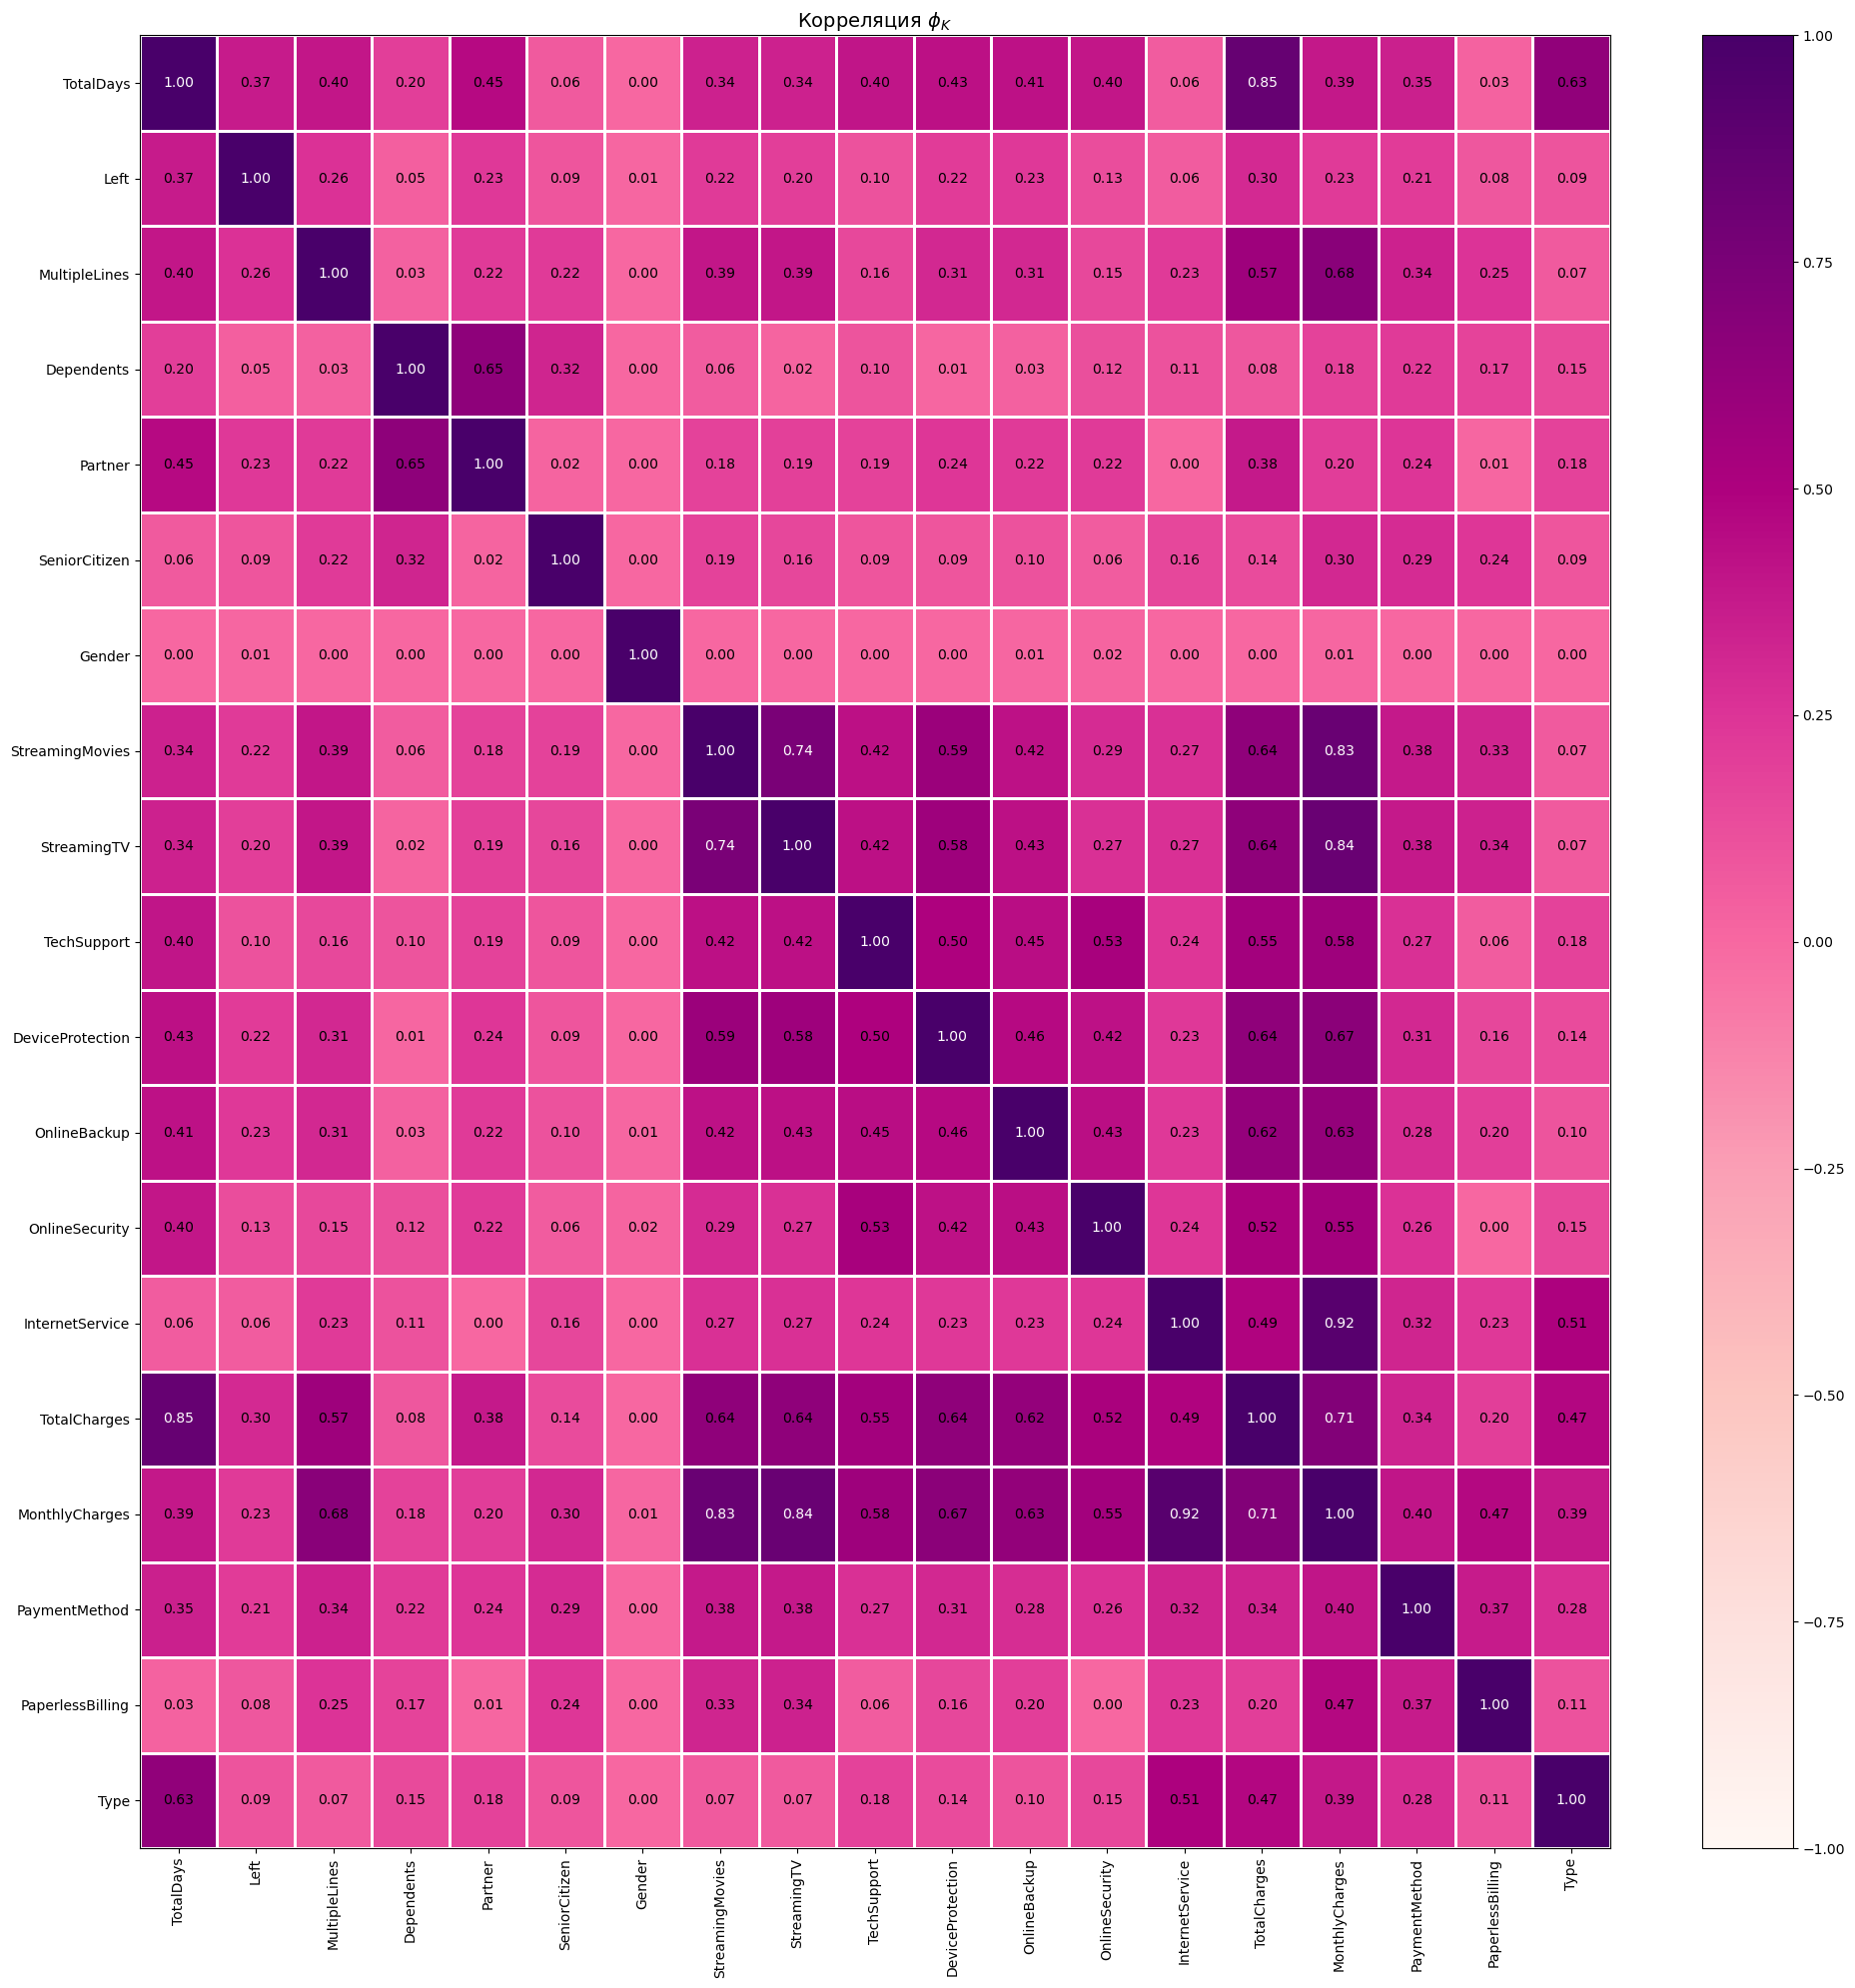

In [31]:
#Посмотрим на корреляцию между столбцами
phik_correlation = data.phik_matrix()
plot_correlation_matrix(phik_correlation.values,
                        x_labels=phik_correlation.columns,
                        y_labels=phik_correlation.index,
                        title='Корреляция $\phi_K$',
                        figsize=(20, 20),
                        color_map='RdPu')

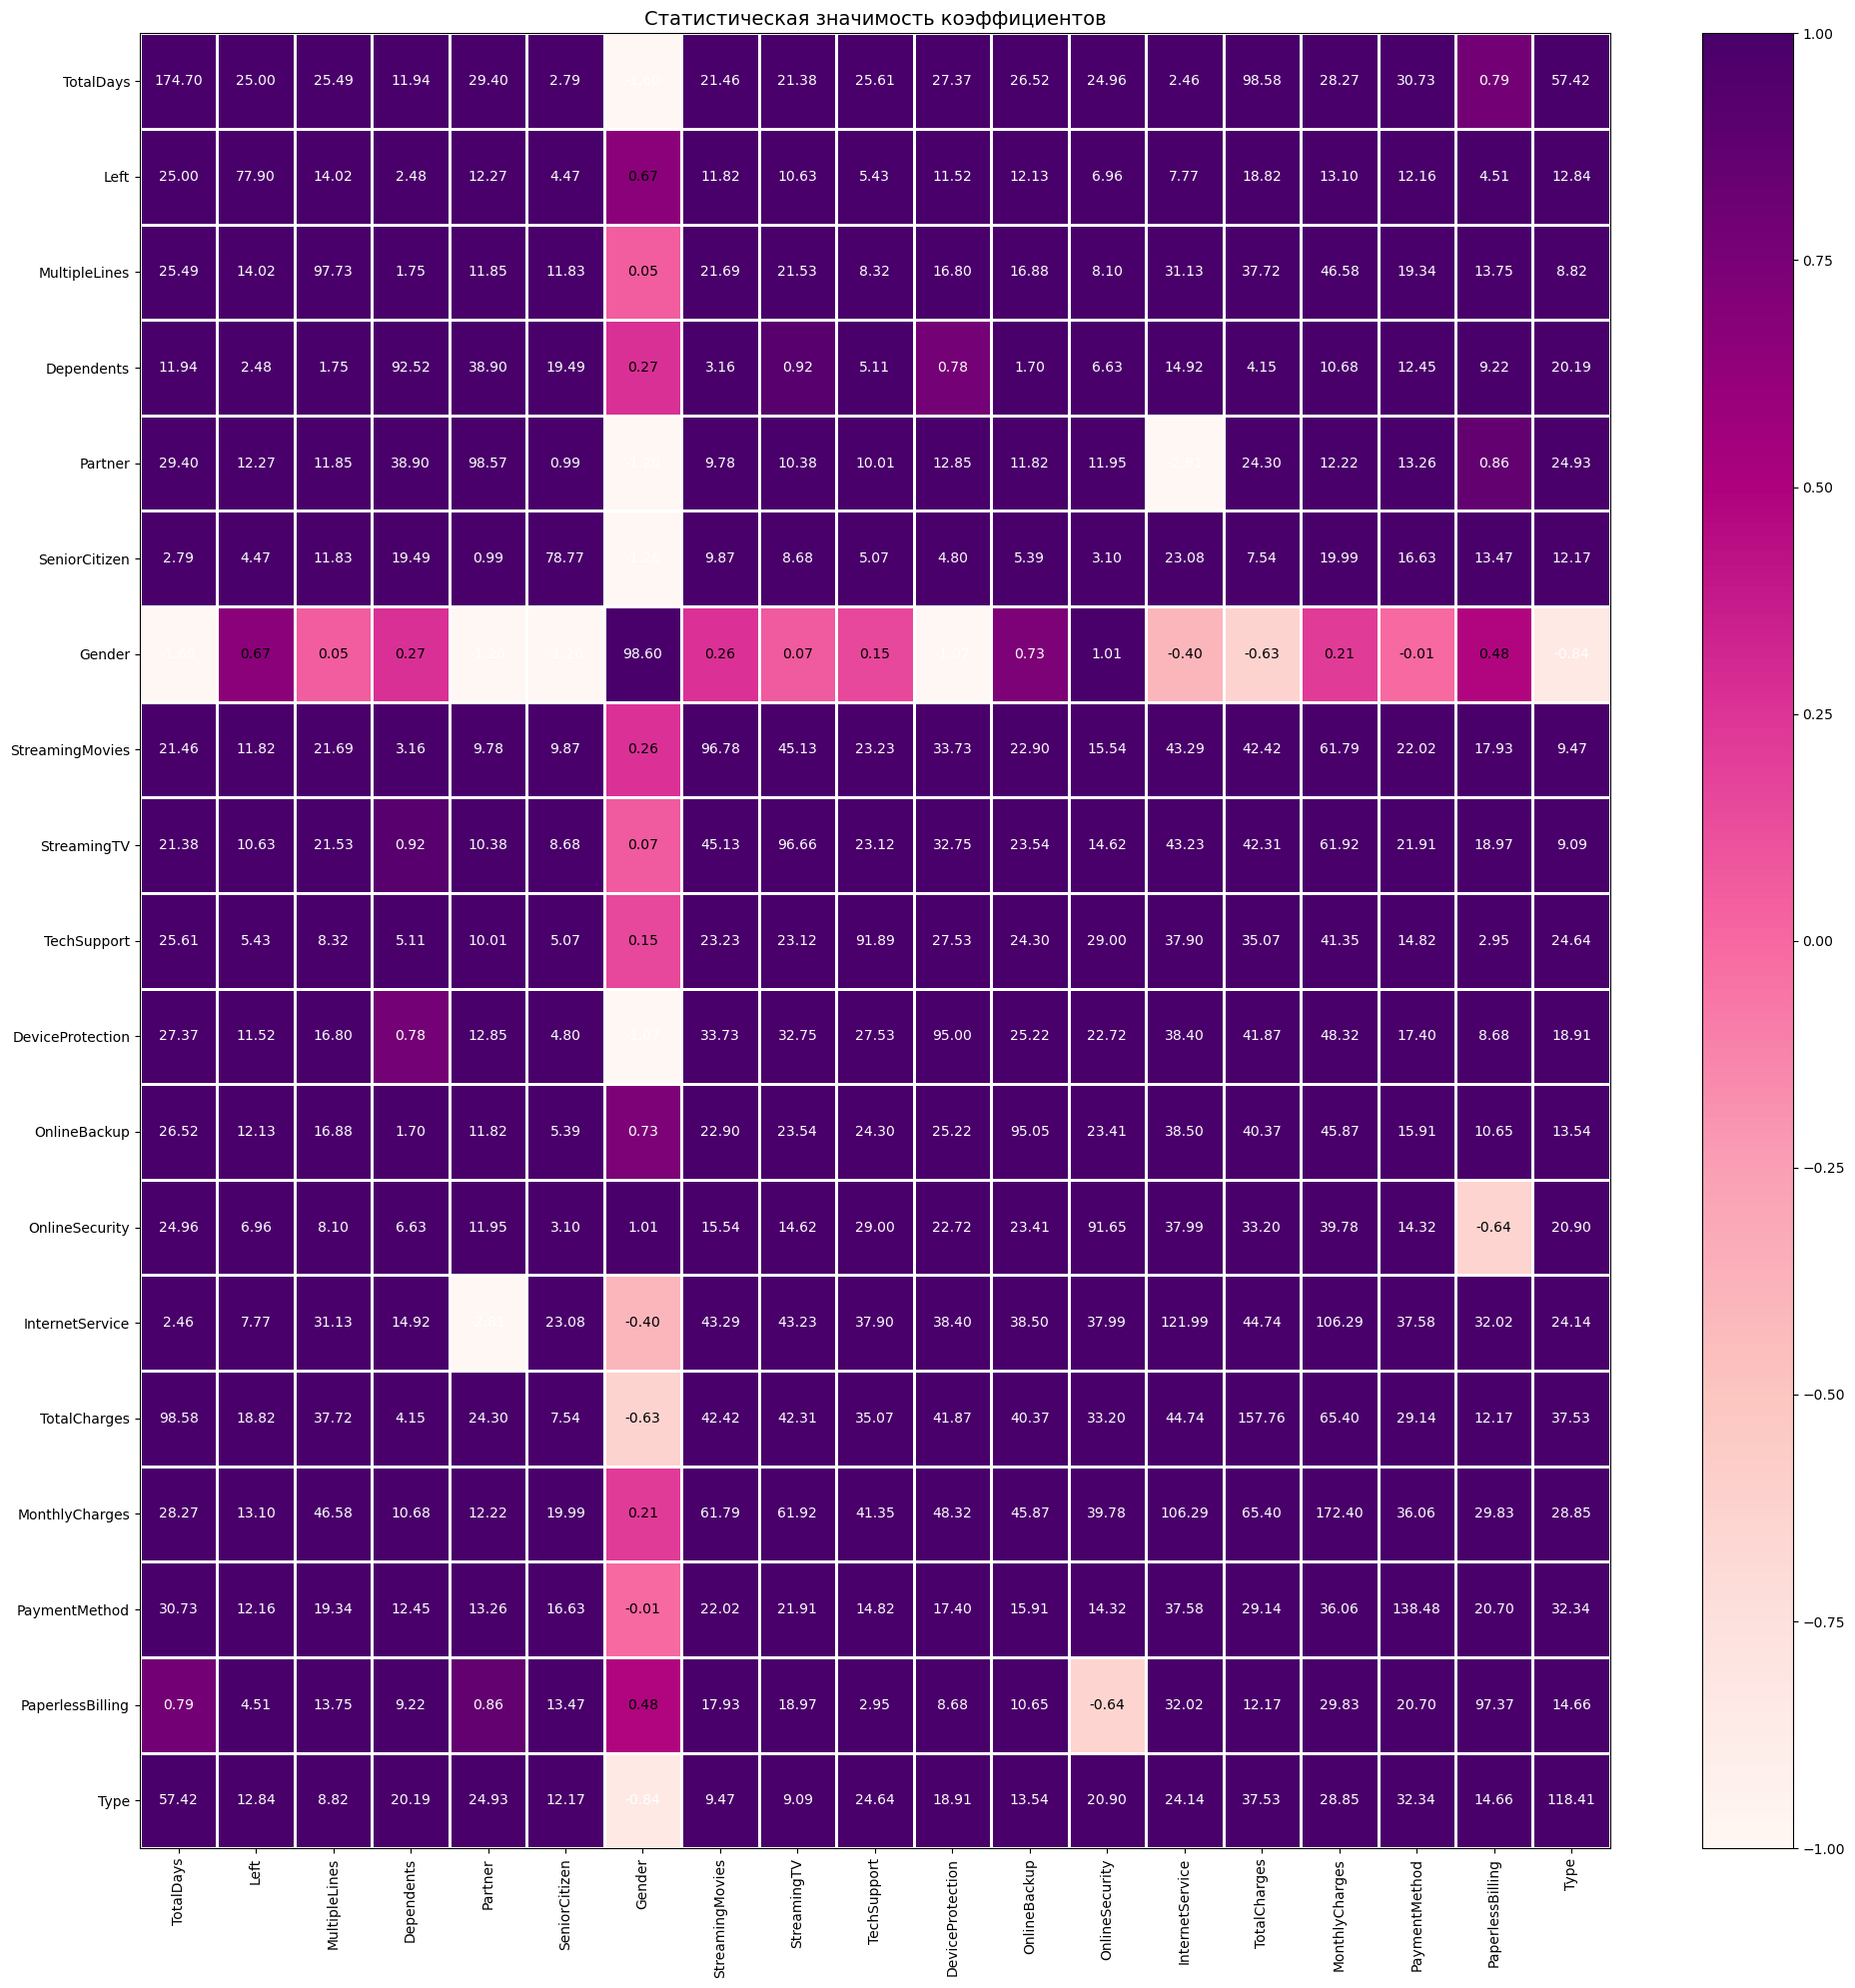

In [32]:
#Посмотрим на статистическую значимость признаков
significance = data.significance_matrix()
plot_correlation_matrix(significance.values, 
                        x_labels=significance.columns, 
                        y_labels=significance.index, 
                        title='Статистическая значимость коэффициентов', 
                        figsize=(20, 20),
                        color_map='RdPu')

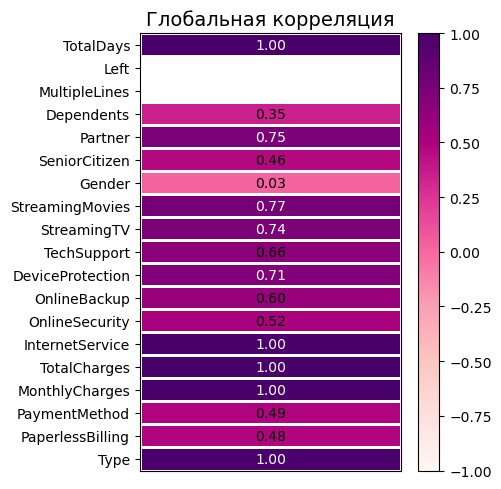

In [33]:
global_correlation, global_labels = data.global_phik()

plot_correlation_matrix(global_correlation, 
                        x_labels=[''], 
                        y_labels=global_labels, 
                        title='Глобальная корреляция', 
                        figsize=(5, 5),
                        color_map='RdPu')

Анализ корреляции показал, что у некоторых признаков достаточно высокий уровень корреляции:

 - TotalDays сильно коррелирует с TotalCharges, что логично, потому что чем больше пользователи является клиентами компании, тем больше заплатили
 - У MonthlyCharges и TotalCharges высокий уровень корреляции с дополнительными услугами
 - Также у дополнительных услуг средний уровень корреляции друг с другом
 
MonthlyCharges и TotalCharges показывают средний или высокий уровень корреляции и представляют одну и ту же информацию, так что можно удалить столбец TotalCharges.

Все столбцы показывают высокий уровень статистической значимости, кроме столбца Gender, так что возможно он не будет играть большую роль в обучении модели. 

Глобальная корреляция показала, что у столбцов TotalDays, InternetCervice, TotalCharges, MonthlyCharges максимальный уровень корреляции по отношению к другим столбцам. При обучении логистической регрессии мультиколлениарность вполне вероятно скажется на результате. В то же время мулитиколлениарность не должна быть проблемой для остальных моделей.

In [34]:
data = data.drop('TotalCharges', axis=1)
data.info()

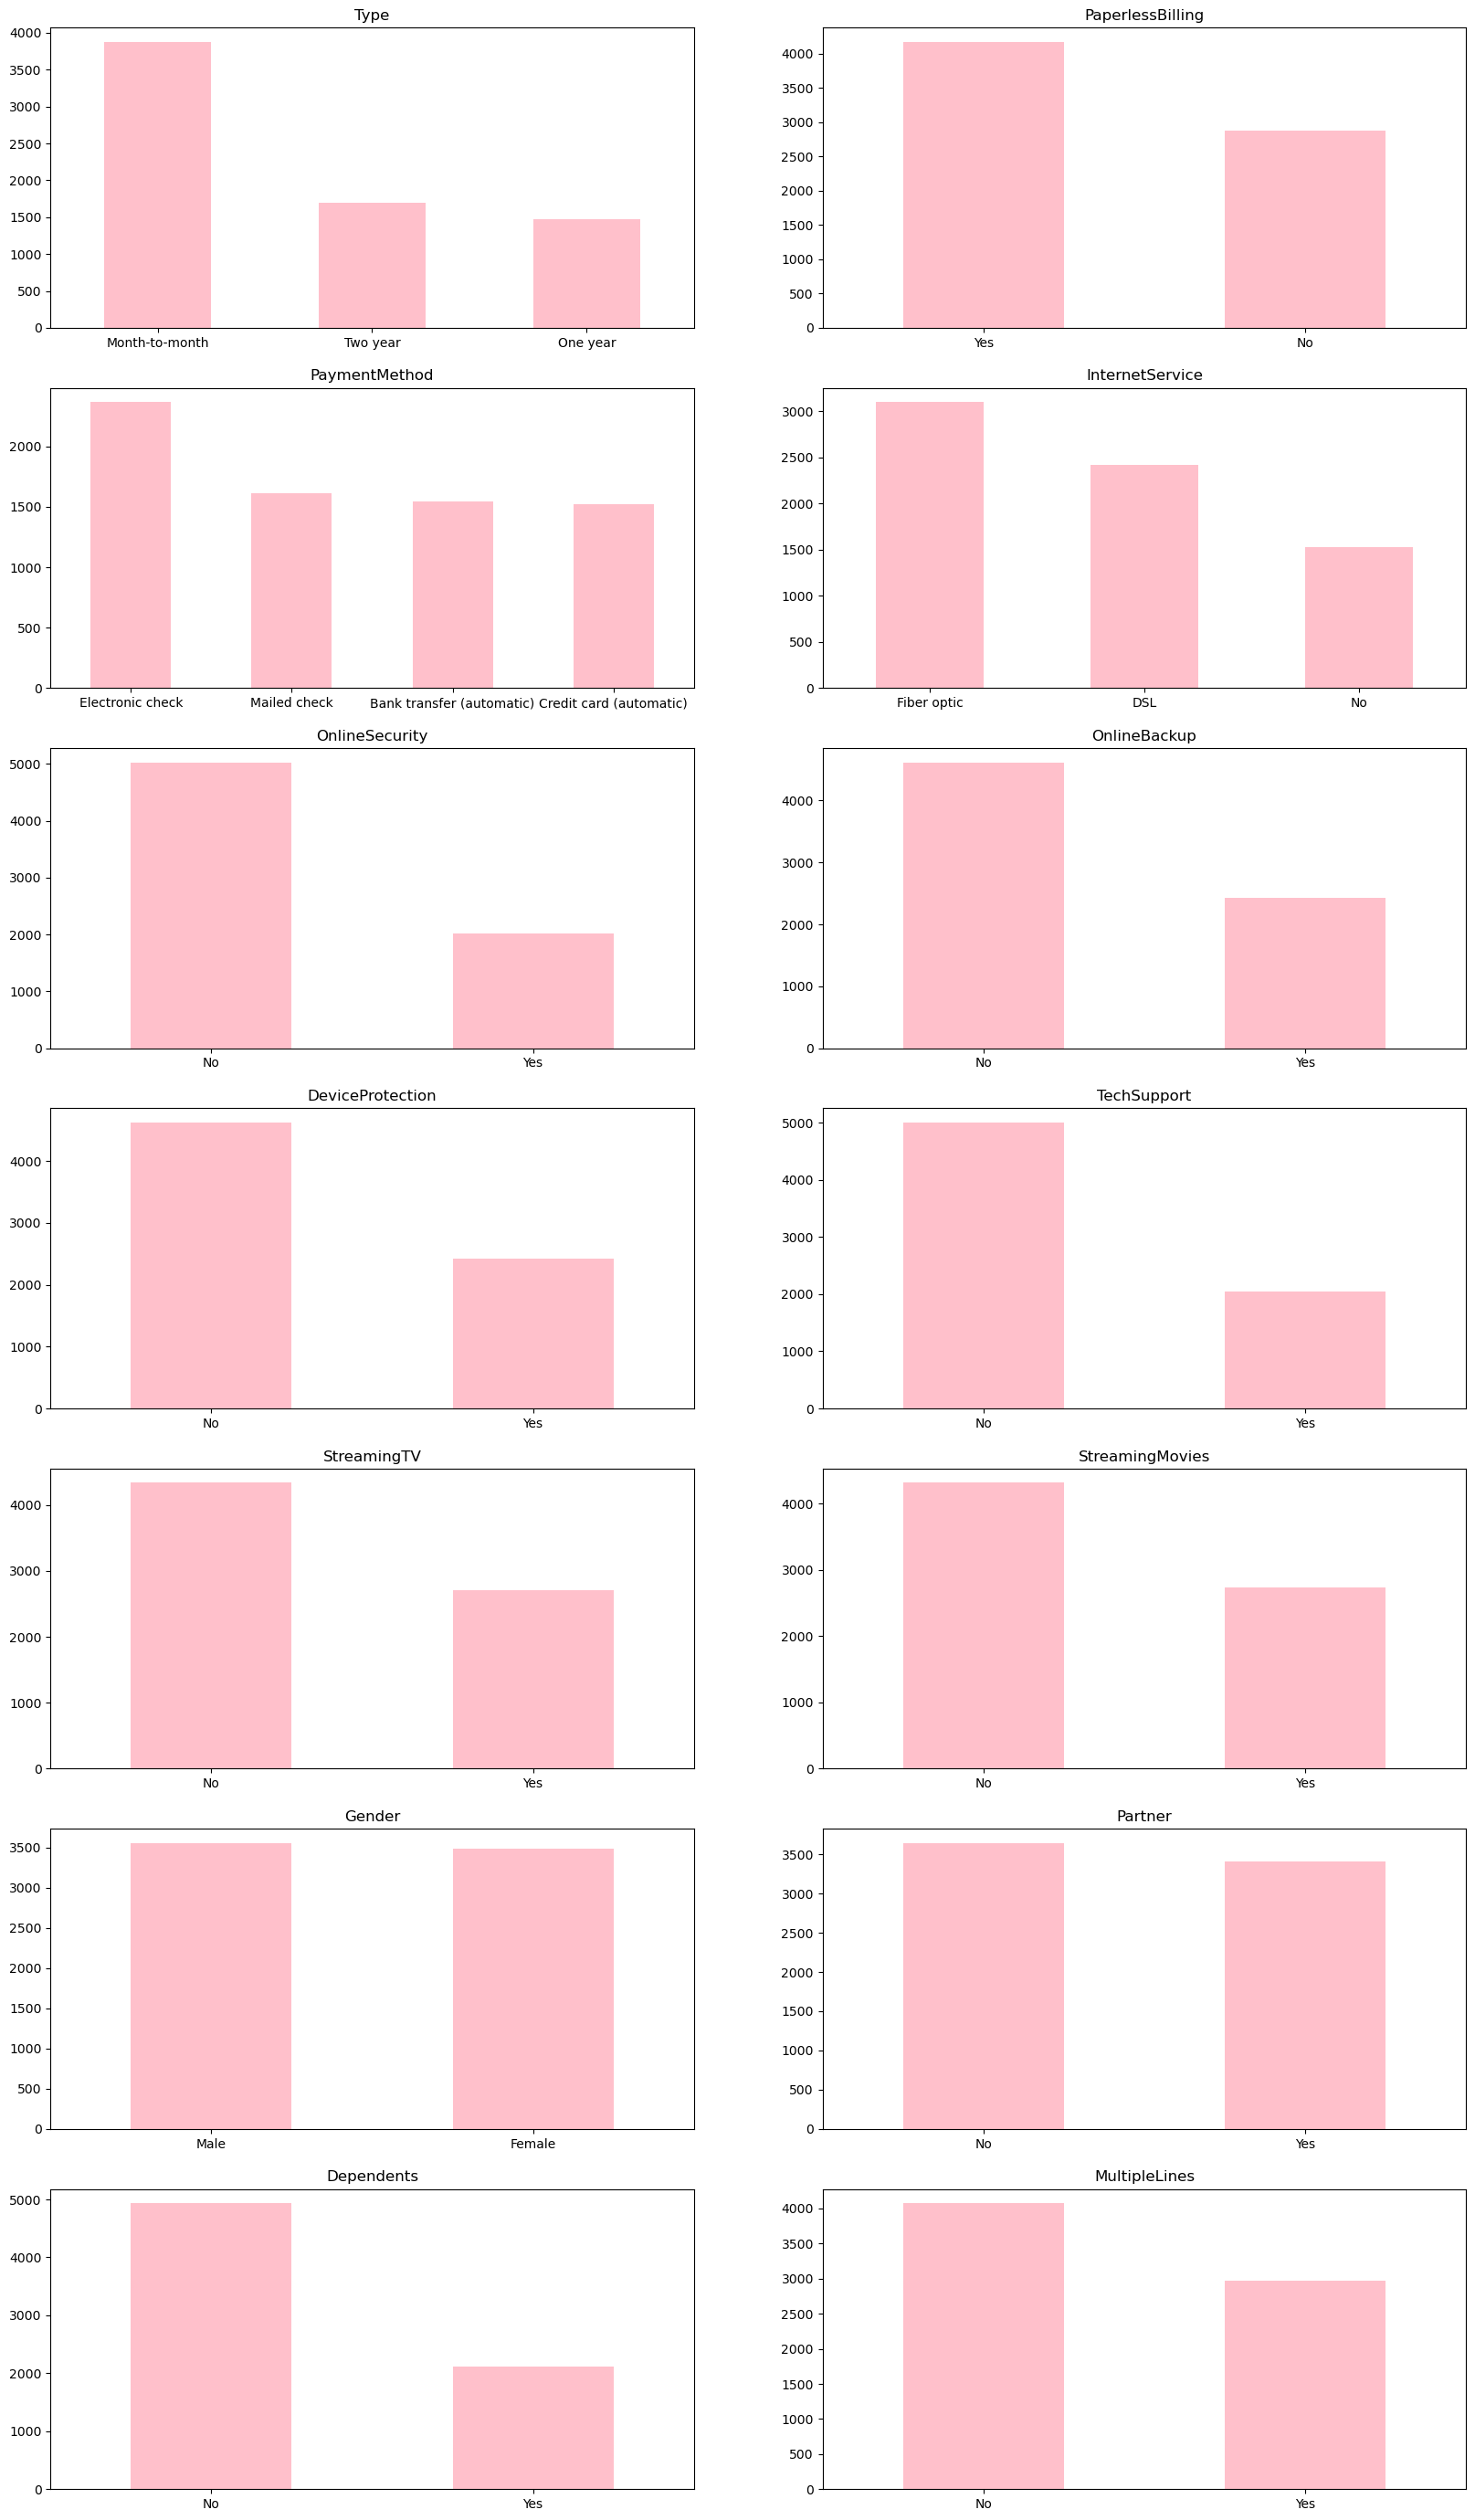

In [59]:
#Распределение категориальных признаков
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()

cols = 2
rows = int(np.ceil(len(categorical_columns) / cols))

plt.figure(figsize=(20, 35))

for idx, column in enumerate(categorical_columns):
    ax = plt.subplot(rows, cols, idx + 1)
    
    data[column].value_counts().plot(
        kind='bar', 
        title=column, 
        ax=ax,
        rot=0,
        color='pink'
    )
        
plt.show()

По распределению категориальных признаков можно увидеть:
 
 - Большая часть клиентов платит за интернет ежемесячно
 - Пользователи предпочитают оплату электронным платёжным документом онлайн (через электронный чек, автоматическое снятие со счёта и кредитную карту)
 - Больше клиентов пользуются интернетом через телефонную линию
 - Количество мужчин и женщин примерно одинаково, как и людей с и без иждивенцев 
 - Дополнительные услуги не пользуются популярностью

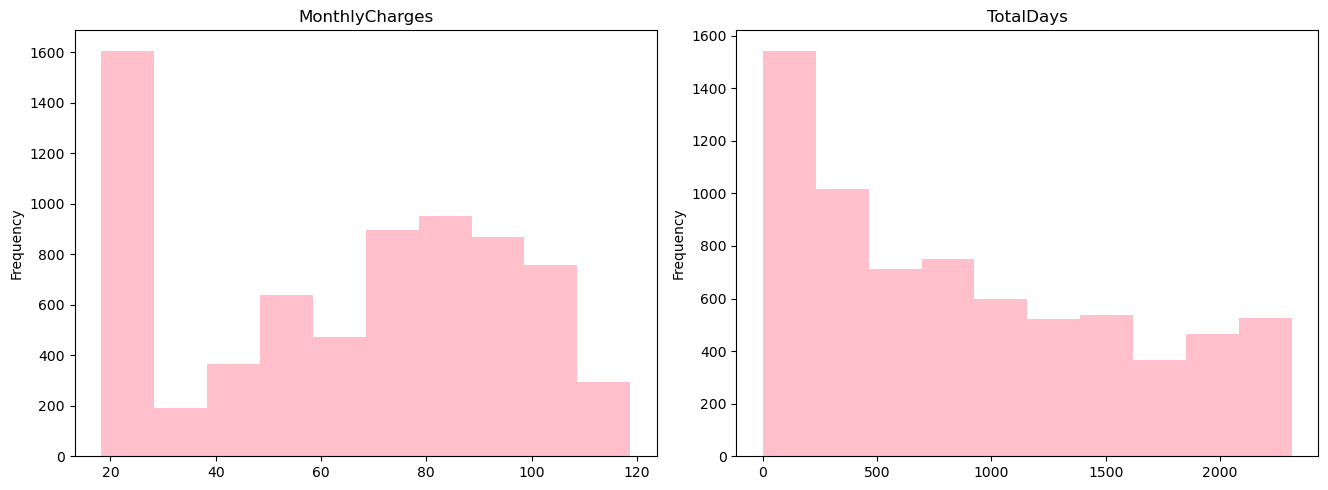

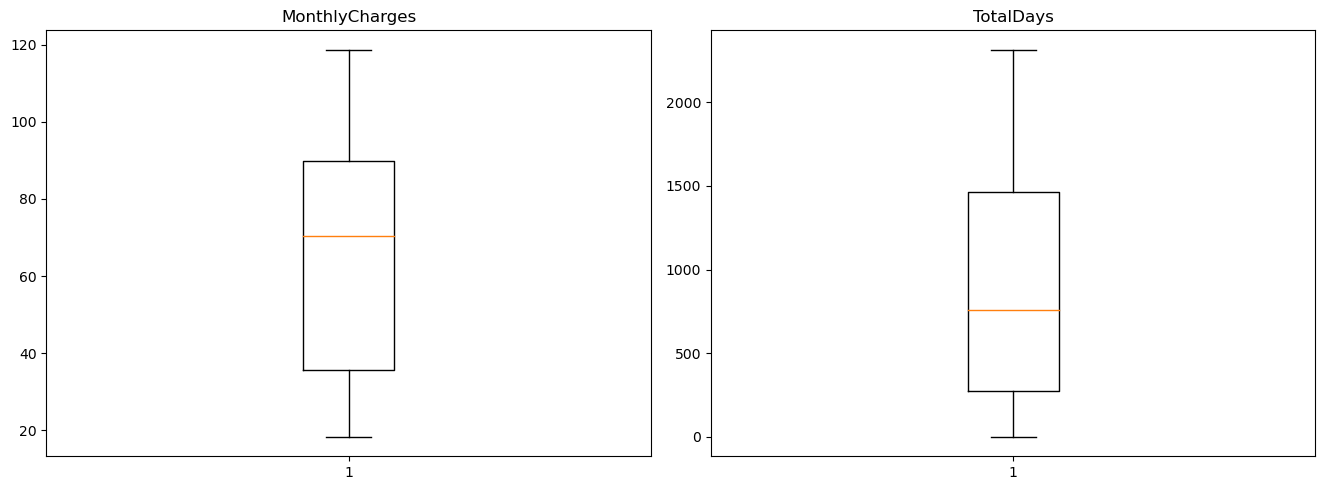

In [36]:
#Распределение числовых признаков
numerical_columns = ['MonthlyCharges', 'TotalDays']

cols = 3
rows = int(np.ceil(len(numerical_columns) / cols))

plt.figure(figsize=(20, 5))

for idx, column in enumerate(numerical_columns):
    ax = plt.subplot(rows, cols, idx + 1)
    
    data[column].plot(
        kind='hist', 
        title=column, 
        ax=ax,
        rot=0,
        color='pink'
    )
plt.tight_layout()    
plt.show()

plt.figure(figsize=(20, 5))
for idx, column in enumerate(numerical_columns):
    ax = plt.subplot(rows, cols, idx + 1)  
    plt.boxplot(data[column])
    plt.title(column)
plt.tight_layout()        
plt.show()

Стоблцы MonthlyCharges и TotalDays распределены ненормально: большое количество пользователей платит от 20 до 30 за интернет в месяц. Кроме того, у компании много долгосрочных клиентов, но также заметно увеличение новых клиентов.

Также, у числовых признаков нет выбросов.

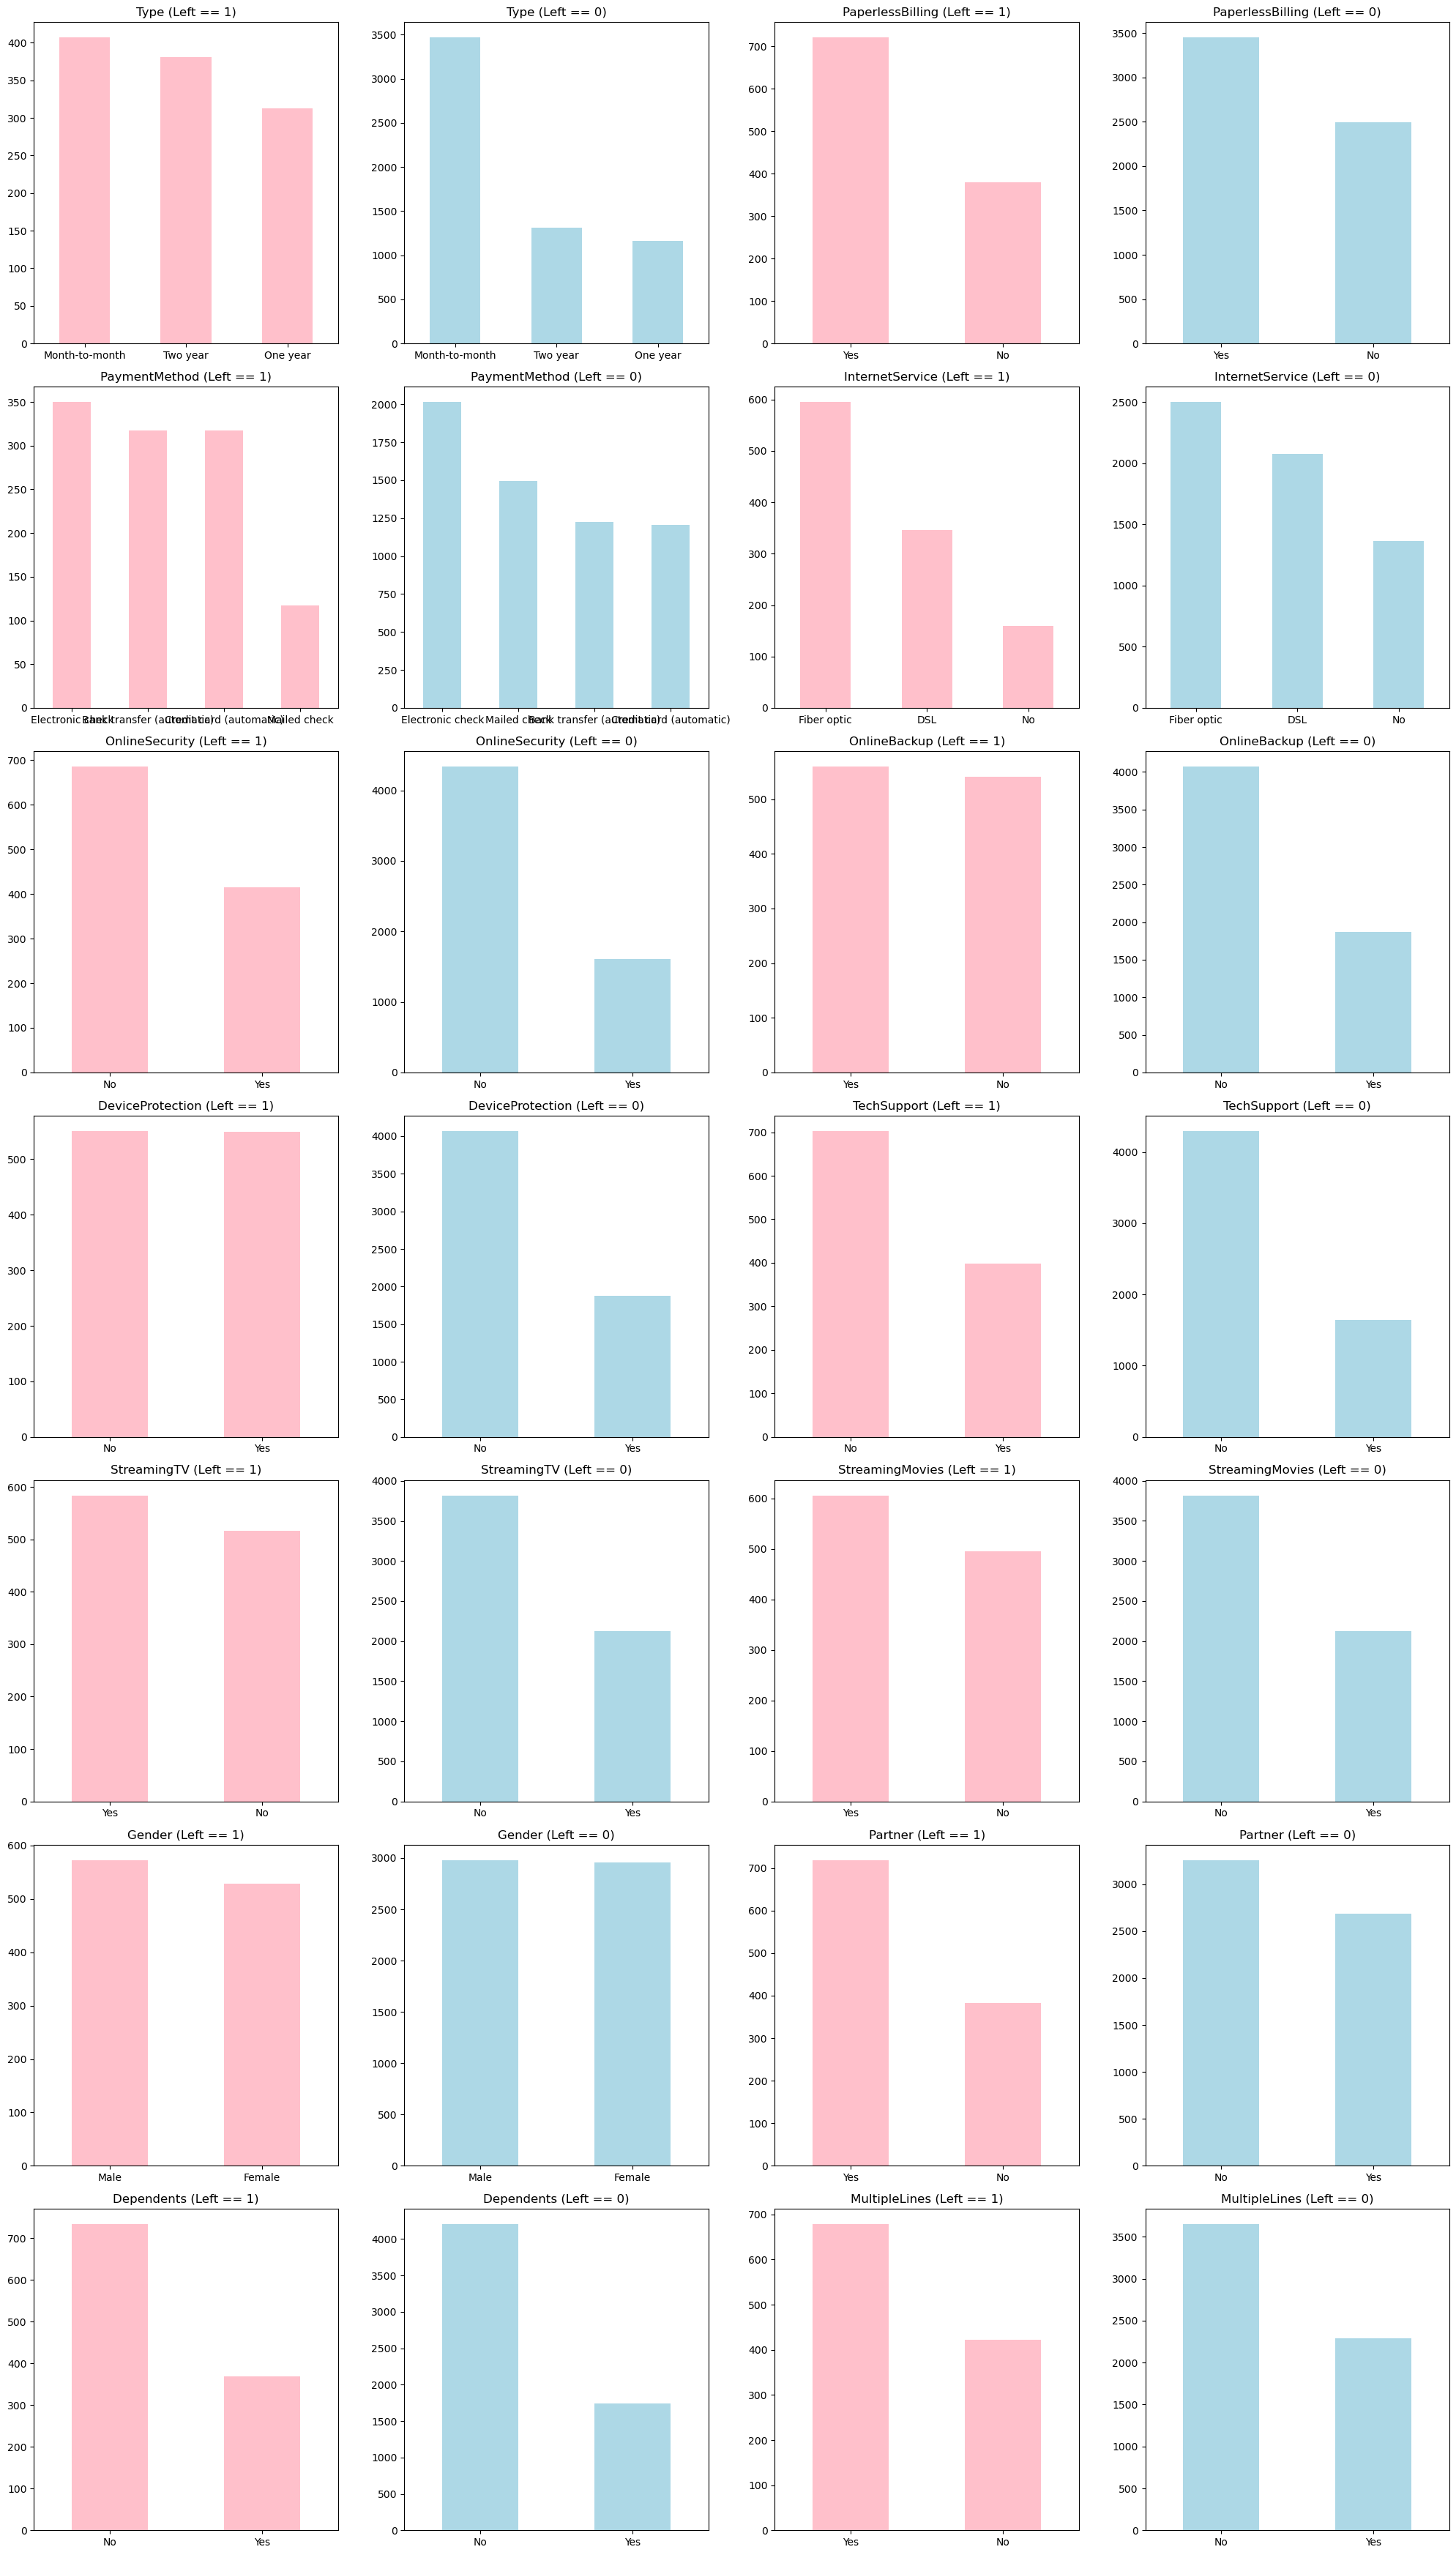

In [37]:
#Распределение категориальных признаков отдельно для ушедших и оставшихся пользователей
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()

cols = 2
rows = int(np.ceil(len(categorical_columns) / cols))

plt.figure(figsize=(20, 35))

for idx, column in enumerate(categorical_columns):
    ax = plt.subplot(rows, 2 * cols, idx * 2 + 1)
    
    data[data['Left'] == 1][column].value_counts().plot(
        kind='bar', 
        title=f'{column} (Left == 1)', 
        ax=ax,
        rot=0,
        color='pink'
    )
    
    ax = plt.subplot(rows, 2 * cols, idx * 2 + 2)
    data[data['Left'] == 0][column].value_counts().plot(
        kind='bar', 
        title=f'{column} (Left == 0)', 
        ax=ax,
        rot=0,
        color='lightblue'
    )

plt.tight_layout()
plt.show()

Проанализировав категориальные признаки для двух групп пользователей, можно отметить несколько особенностей:

 - Ушедшие пользователи заключали все виды контрактов, в то время как большинство оставшихся - в основном ежемесячные
 - Среди ушедших было много пользователей оптоволоконного интернета
 - Многие ушедшие были подключены к дополнительным услугам: антивирусу (DeviceProtection), облачному хранилищу (OnlineBackup), стриминговому тв (StreamingTV), каталогу фильмов (StreamingMovies) и параллельными линиями (MultipleLines).
 - Также среди ушедших было больше людей, состоящих в браке
 
Можно предположить, что на решение пользователей уйти повлияло качество дополнительх услуг и оптоволоконного интернета.

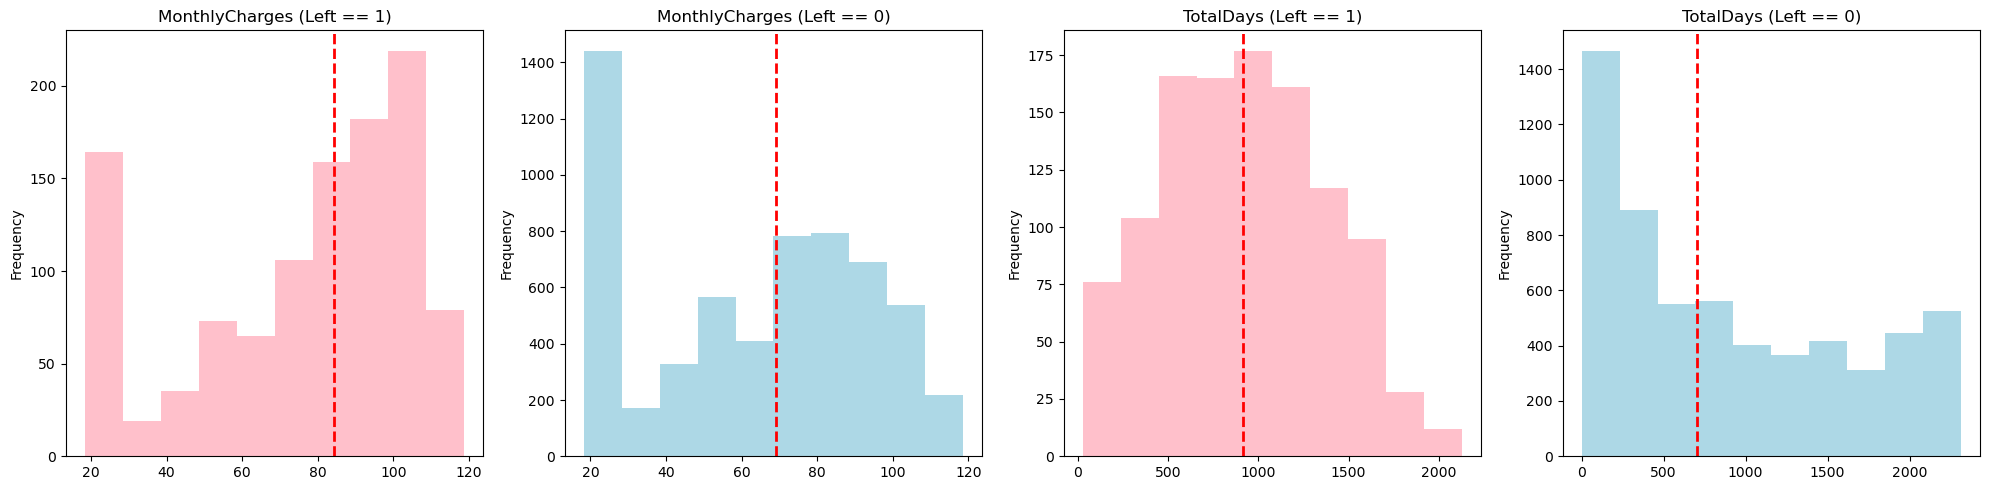

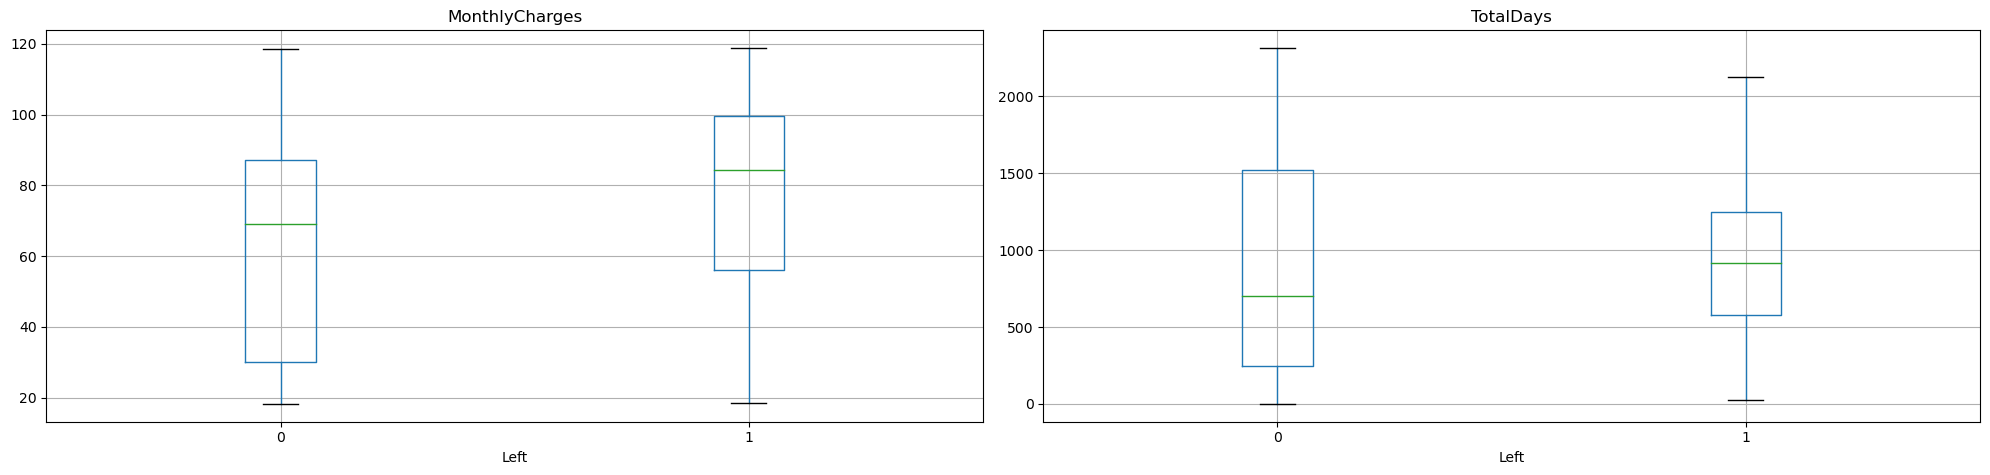

In [38]:
#Распределение числовых признаков отдельно для ушедших и оставшихся пользователей
numerical_columns = ['MonthlyCharges', 'TotalDays']

cols = 2
rows = int(np.ceil(len(numerical_columns) / cols))

plt.figure(figsize=(20, 5))

for idx, column in enumerate(numerical_columns):
    ax = plt.subplot(rows, 2 * cols, idx * 2 + 1)
    
    data[data['Left'] == 1][column].plot(
        kind='hist', 
        title=f'{column} (Left == 1)', 
        ax=ax,
        rot=0,
        color='pink'
    )
    plt.axvline(data[data['Left'] == 1][column].median(), color='red', linestyle='dashed', linewidth=2)
    
    ax = plt.subplot(rows, 2 * cols, idx * 2 + 2)
    data[data['Left'] == 0][column].plot(
        kind='hist', 
        title=f'{column} (Left == 0)', 
        ax=ax,
        rot=0,
        color='lightblue'
    )
    plt.axvline(data[data['Left'] == 0][column].median(), color='red', linestyle='dashed', linewidth=2)

plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 5))
for idx, column in enumerate(numerical_columns):
    ax = plt.subplot(rows, cols, idx + 1)  
    data.boxplot(column=column, by='Left', ax=ax)
    plt.title(f'{column}')
    plt.suptitle('')  

plt.tight_layout()
plt.show()

Сравнив ушедших и оставшихся пользователей, можно заметить:

 - Компания потеряла долгосрочных пользователей (в среднем 900 дней), плативших почти 80 евро в месяц
 - Оставшиеся пользователи являются клиентами компании около 600 дней и платят в среднем 70 евро в месяц
 
Таким образом, от услуг компании отказались клиенты, которые долгий срок пользовались услугами и платили в среднем больше, чем оставшиеся.

## Обучение моделей

In [39]:
#Разделим датасет на тренировочную и тестовые выборки
features = data.drop(['Left'], axis=1)
target = data['Left']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE
)

print('Тренировочная выборка: ', features_train.shape[0] / features.shape[0] * 100)
print('Тестовая выборка: ', features_test.shape[0] / features.shape[0] * 100)

In [40]:
#Категориальные признаки
ohe_features = features_train.select_dtypes(include='object').columns.to_list()
print(ohe_features)

In [41]:
#Числовые признаки
#'SeniorCitizen' — категориальный бинарный признак, так что уберём его из списка
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
num_features.remove('SeniorCitizen')
num_features

In [42]:
features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()

In [43]:
#Закодируем и замасштабируем данные
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

encoder_ohe.fit(features_train_ohe[ohe_features])

features_train_ohe[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train_ohe[ohe_features])

features_train_ohe = features_train_ohe.drop(ohe_features, axis=1)

scaler = StandardScaler()

features_train_ohe[num_features] = scaler.fit_transform(features_train_ohe[num_features])

features_train_ohe.head()

In [44]:
features_test_ohe[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test_ohe [ohe_features])

features_test_ohe = features_test_ohe.drop(ohe_features, axis=1)

features_test_ohe[num_features] = scaler.transform(features_test_ohe[num_features])

features_test_ohe.head()

#### Логистическая регрессия

In [45]:
#Обучим Логистическую регрессию
parameters_log = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'max_iter': [100, 200, 500]
}

model_log = LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=RANDOM_STATE)

gs_log = GridSearchCV(model_log, parameters_log, cv=5, scoring='roc_auc')
gs_log.fit(features_train_ohe, target_train)

print(f'AUC-ROC составляет: {gs_log.best_score_}')
print(f'Лучшие параметры: {gs_log.best_params_}')

#### Решающее дерево

In [46]:
pipeline_tree = Pipeline(
    [('dtree', DecisionTreeClassifier(random_state=RANDOM_STATE))])

parameters_tree = {
    'dtree__max_depth': range(2, 15),
    'dtree__min_samples_split': [2, 3, 4],
    'dtree__min_samples_leaf': [1, 2, 3, 4]
}

gs_tree = RandomizedSearchCV(pipeline_tree, parameters_tree, cv=3, n_jobs=-1, scoring='roc_auc')
gs_tree.fit(features_train_ohe, target_train)
predicted_probalities_tree = gs_tree.best_estimator_.predict_proba(features_test_ohe)[:, 1]

print(f'AUC-ROC составляет: {gs_tree.best_score_}')
print(f'Лучшие параметры: {gs_tree.best_params_}')

#### Случайный лес

In [47]:
pipeline_forest = Pipeline(
    [('dforest', RandomForestClassifier(random_state=RANDOM_STATE, verbose=0))])

parameters_forest = {
    'dforest__n_estimators': range(50, 251, 50),
    'dforest__max_depth': range(2, 15),
    'dforest__min_samples_split': (2, 3, 4),
    'dforest__min_samples_leaf': (1, 2, 3, 4)
}

gs_forest = RandomizedSearchCV(pipeline_forest, parameters_forest, cv=3, n_jobs=-1, scoring='roc_auc')
gs_forest.fit(features_train_ohe, target_train)

print(f'AUC-ROC составляет: {gs_forest.best_score_}')
print(f'Лучшие параметры: {gs_forest.best_params_}')

#### CatBoostClassifier

In [48]:
pipeline_catboost = Pipeline(
    [('dcat', CatBoostClassifier(random_state=RANDOM_STATE, verbose=False))])

parameters_catboost = {
    'dcat__iterations': np.arange(100, 1000, 100),  
    'dcat__learning_rate': [0.01, 0.05, 0.1, 0.2],  
    'dcat__depth': np.arange(3, 11),  
    'dcat__l2_leaf_reg': [1, 3, 5, 7], 
}

gs_catboost = RandomizedSearchCV(pipeline_catboost, parameters_catboost, cv=3, n_jobs=-1, scoring='roc_auc', verbose=3)
gs_catboost.fit(features_train_ohe, target_train)

print(f'AUC-ROC составляет: {gs_catboost.best_score_}')
print(f'Лучшие параметры: {gs_catboost.best_params_}')

In [49]:
results = pd.DataFrame(
    [gs_log.best_score_, 
     gs_tree.best_score_, 
     gs_forest.best_score_, 
     gs_catboost.best_score_], 
    index=['Логистическая регрессия', 'Решающее дерево', 'Случайный лес', 'CatBoostClassifier'], 
    columns=['ROC-AUC']
)
results

Самый лучший результат показала модель CatBoostClassifier (0.899), что выше заданого порога в 0.85. Посмотрим, какие признаки сыграли наибольшую роль при обучении.

In [50]:
importance = pd.DataFrame(gs_catboost.best_estimator_.named_steps['dcat'].feature_importances_, 
                          index = features_train_ohe.columns, columns=['Важность'])
importance = importance.sort_values(by='Важность', ascending=False)
importance

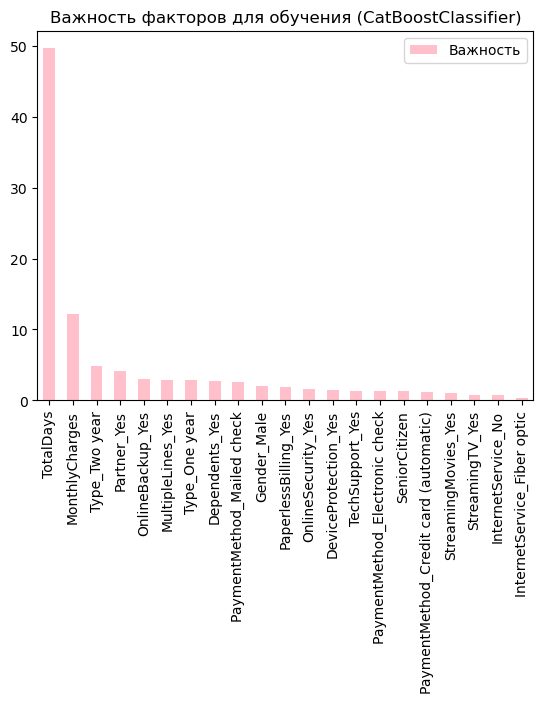

In [51]:
importance.plot(kind='bar', color='pink', title='Важность факторов для обучения (CatBoostClassifier)')
plt.show()

Самыми важными факторами для обучения модели оказались TotalDays, MonthlyCharges, Type(Two year) и Partner(Yes).

In [52]:
#Проверим модель на тестовой выборке
catboost_pred = gs_catboost.predict_proba(features_test_ohe)[:, 1]

roc_auc_test = roc_auc_score(target_test, catboost_pred)
print(f'ROC-AUC на тестовой выборке: {roc_auc_test}')

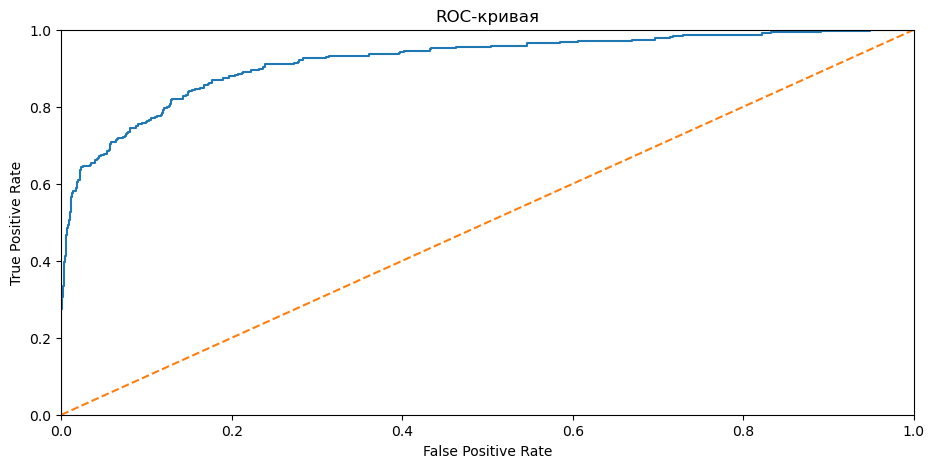

In [53]:
#Построим ROC-кривую
fpr, tpr, thresholds = roc_curve(target_test, catboost_pred)

plt.figure(figsize=(11, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
    
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
    
plt.title('ROC-кривая')  
plt.show()

Модель показала хороший результат на тестовой выборке (0.918), что означает, что она точно предсказывает вероятность ухода клиента.

In [54]:
threshold = 0.5
catboost_pred_binary = np.where(catboost_pred > threshold, 1, 0)

accuracy = accuracy_score(target_test, catboost_pred_binary)
print(f'Точность модели на тестовой выборке составила {accuracy}')

In [55]:
matrix = confusion_matrix(target_test, catboost_pred_binary)

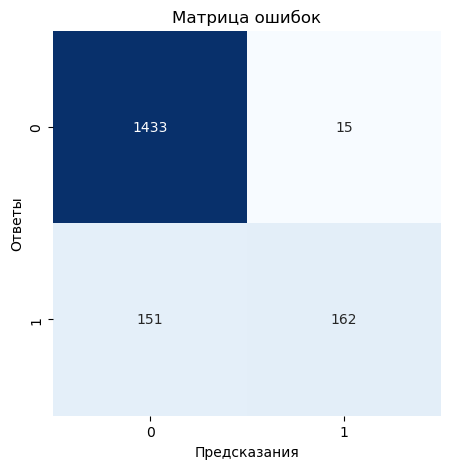

In [56]:
plt.figure(figsize=(5, 5))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Предсказания')
plt.ylabel('Ответы')
plt.title('Матрица ошибок')
plt.show()

In [57]:
catboost_pred = gs_catboost.predict_proba(features_test_ohe)[:, 1]

test_pool = Pool(features_test_ohe, label=target_test)
feature_importances_test = gs_catboost.best_estimator_.named_steps['dcat'].get_feature_importance(data=test_pool, type="LossFunctionChange")

importance_test = pd.DataFrame({'Feature': features_test_ohe.columns, 'Важность': feature_importances_test})
importance_test = importance_test.sort_values(by='Важность', ascending=False)
importance_test = importance_test.set_index('Feature')

importance_test

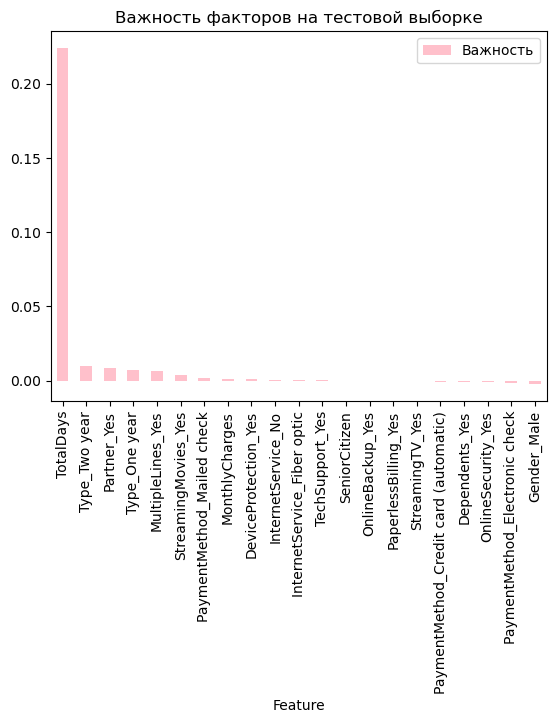

In [58]:
importance_test.plot(kind='bar', color='pink', title='Важность факторов на тестовой выборке')
plt.show()

Для тестовой выборки наибольшую роль сыграли признаки TotalDays, Partner_Yes, MultipleLines_Yes, Type_One_year, Type_Two_Year, в то время как остальные не сыграли большой роли.

## Вывод

Для анализа стояла задача обучить модель, которая сможет предсказывать уход клиентов телекоммуникационной компании. Для этого были предоставлены четыре датасета с данными пользователей.

В ходе предварительного анализа данных были объединены таблицы, устранены пропуски, создан новый признак TotalDays и устранены два признака с датами.

Затем была рассмотрени корреляция и значимость признаков, а также динамика признаков у ушедших и оставшихся пользователей. Было показано, что из компании уходили пользователи, долго пользовавшиеся услугами компании и платившие около 80 евро в месяц. Среди возможных причин ухода пользователей были отмечены недовольство дополнительными услугами и качеством оптоволоконного интернета.

Затем были обучены четыре модели: логистическая регрессия, решающее дерево, случайный лес и CatBoostClassifier. В итоге самый лучший результат на AUC-ROC показал CatBoostClassifier с 0.90 на тренировочной и 0.92 на тестовой выборках, что означает, что модель хорошо справляется с распознованием и может быть применена к задаче.

Самыми важными признаками для обучения модели стали количество дней пользования услугами компании, месячная оплата, тип контракта и наличие партнёра. На тестовой выборке самым главным признаком осталось количество дней.

## Отчёт по решению

Целью работы было обучить модель, способную предсказывать потенциальный уход клиентов из телекоммуникационной компании. У модели метрика AUC-ROC должна была быть выше 0.85.

Компания предоставляет услуги телефонной связи, интернета и дополнительные услуги, связанные в интернетом (антивирус, блокировка небезопасных сайтов, выделенная линия технической поддержки , облачное хранилище файлов для резервного копирования данных, стриминговое телевидение и каталог фильмов). 

Для анализа компания предоставила четыре датасета:
- `contract_new.csv` — информация о договоре
- `personal_new.csv` — персональные данные клиента
- `internet_new.csv` — информация об интернет-услугах
- `phone_new.csv` — информация об услугах телефонии

Во всех файлах был указан код клиента (столбец customerID). Информация была выгружена 1 февраля 2020.

Для анализа были выделены четыре основных шага:
 1) Предварительный анализ данных
 2) Предобработка данных
 3) Анализ признаков
 4) Обучение и проверка модели

#### Предварительный анализ данных
Сначала данные были загружены датасеты, просмотрена информация о них. Также, были изменены типы признаков TotalCharges (на числовой) и BeginDate (на дату) и обработаны пропуски, получившиеся из-за этого.

Затем были объеденены таблицы. В итоге в данных были выделены следующие признаки:
 - BeginDate – дата начала пользования услугами
 - EndDate – дата окончания пользования услугами
 - Type – тип оплаты: ежемесячный, годовой, двухгодовой
 - PaperlessBilling – электронный платёжный документ
 - PaymentMethod – способ оплаты: электронный чек, чек по почте, банковский перевод, кредитной картой
 - MonthlyCharges – ежемесячные траты на услуги
 - TotalCharges – всего потрачено денег на услуги
 - InternetService - тип интернета: через телефонную линию (DSL), оптоволоконный кабель (Fiber optic) или его отсутствие
 - DeviceProtection - антивирус 
 - OnlineSecurity - блокировка небезопасных сайтов
 - TechSupport - выделенная линия технической поддержки
 - OnlineBackup -  облачное хранилище файлов для резервного копирования данных 
 - StreamingTV - стриминговое телевидение 
 - StreamingMovies - каталог фильмов
 - Gender - гендерная принадлежность пользователя
 - Dependents – наличие иждивенцев
 - Senior Citizen – наличие пенсионного статуса по возрасту
 - Partner – наличие супруга(и)
 - MultipleLines – наличие возможности ведения параллельных линий во время звонка

#### Предобработка данных
После объеденения таблицы получилось 1526 пропусков в признаках InternetService, дополнительных услуг и MultipleLines у пользователей с неподключённым интернетом, так что пропуски были заменены на 'No'.

Также, был создан новые признаки TotalDays (общее количество дней пользования услугами компании) и Left (ушёл клиент или нет), который стал целевым признаком. Чтобы избежать утечки данных, были удалены признаки BeginDate и EndDate.

#### Анализ данных
Затем были составлены матрицы корреляции и статистической значимости признаков. Матрицы показали высокую корреляцию TodalDays и TotalCharges, TotalCharges и MonthlyCharges, и корреляцию дополнительных услуг между собой. Чтобы снизать уровень мультиколлениарности, признак TotalCharges был в итоге удалён. Анализ статистической значимости покзазал, что признак Gender не будет играть большой роли в обучении модели.

Затем были рассмотрены распределения категориальных и числовых признаков по отдельности и в зависимости от целевого признака. 

В результате анализа были сделаны следующие вывод:

 - Ушедшие пользователи заключали все виды контрактов, в то время как среди оставшихся преобладали ежемесячные
 - Среди ушедших было много пользователей оптоволоконного интернета
 - Многие ушедшие были подключены к дополнительным услугам: антивирусу (DeviceProtection), облачному хранилищу (OnlineBackup), стриминговому тв (StreamingTV), каталогу фильмов (StreamingMovies) и параллельными линиями (MultipleLines)
 - Компания потеряла долгосрочных пользователей (900 дней в среднем)
 - Ушедшие пользователи платили за услуги на 10 евро больше, чем оставшиеся
 
Поэтому было сделано предположение, что на решение клиентов уйти сыграла цена услуг, качество оптоволоконного интернета и качество дополнительных услуг.

#### Обучение и проверка модели
После анализа данные были разделены на тренировочную и тестовую выборки в соотношении 75%-25%, категориальные признаки были закодированы, а числовые - замасштабированы.

Затем были обучены четыре модели: логистическая регрессия, решающее дерево, случайный лес и CatBoostClassifier.

Самый лучший результат показал CatBoostClassifier: ROC-AUC 0.906 на тренировочной и 0.921 на тестовой выборке. У модели были определены следующие гиперпараметры:
 - learning_rate: 0.1
 - l2_leaf_reg': 1
 - iterations': 600
 - depth: 6
 - RANDOM_STATE: 100723
 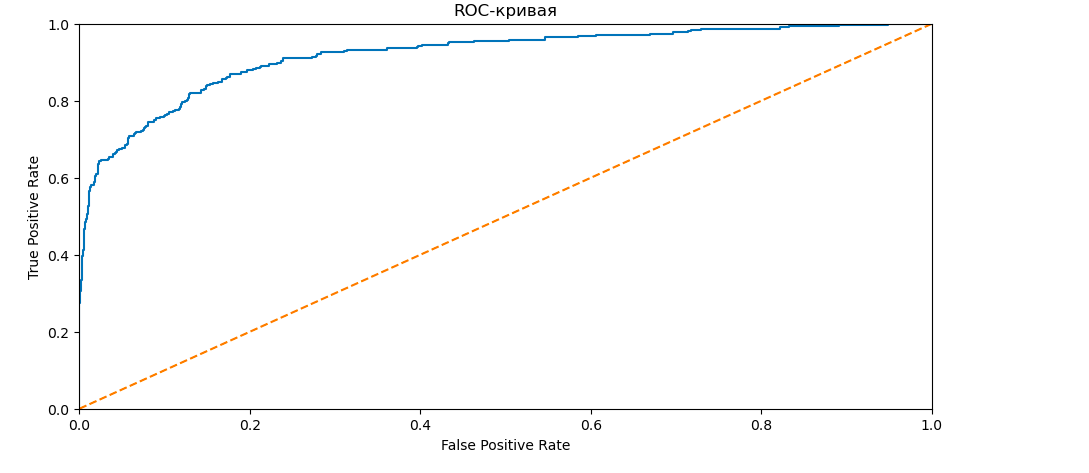
 
Также, была изучены важность признаков при обучении, и самыми важными оказались TotalDays, MonthlyCharges, Type(Two year) и Partner(Yes). Для тестовой выборки важными оказались TotalDays, Partner (Yes), MultipleLines (Yes), Type (One year), Type (Two year).
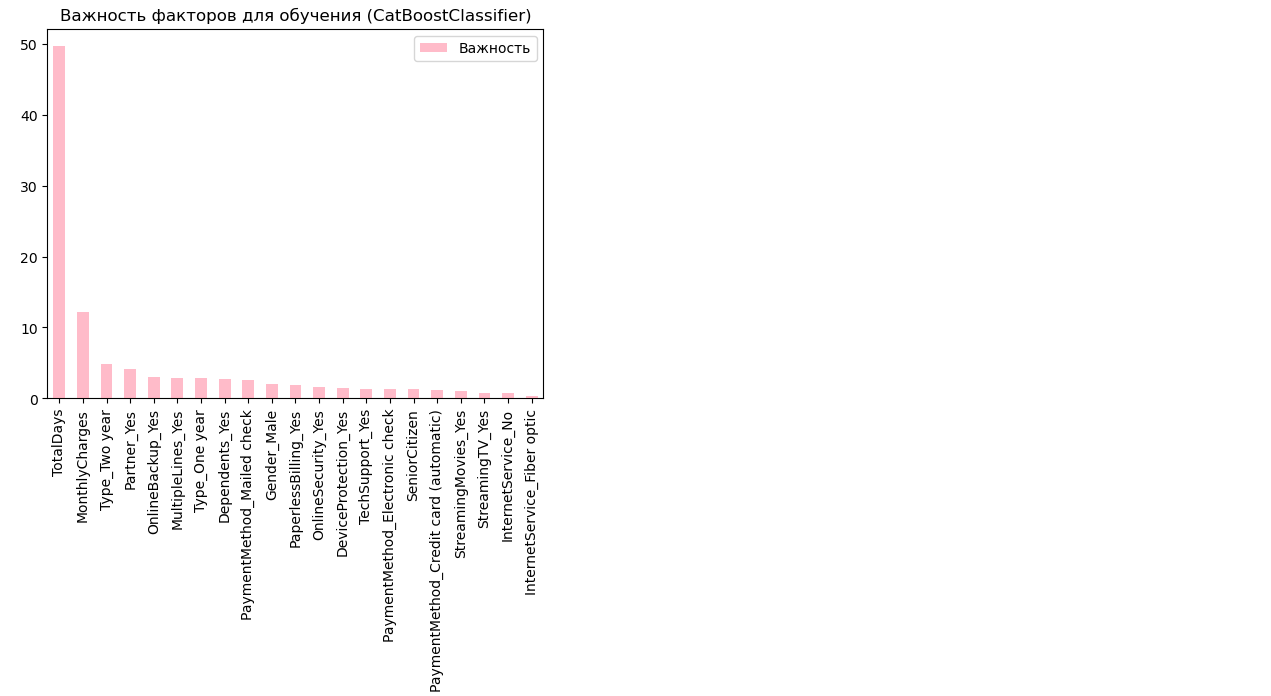
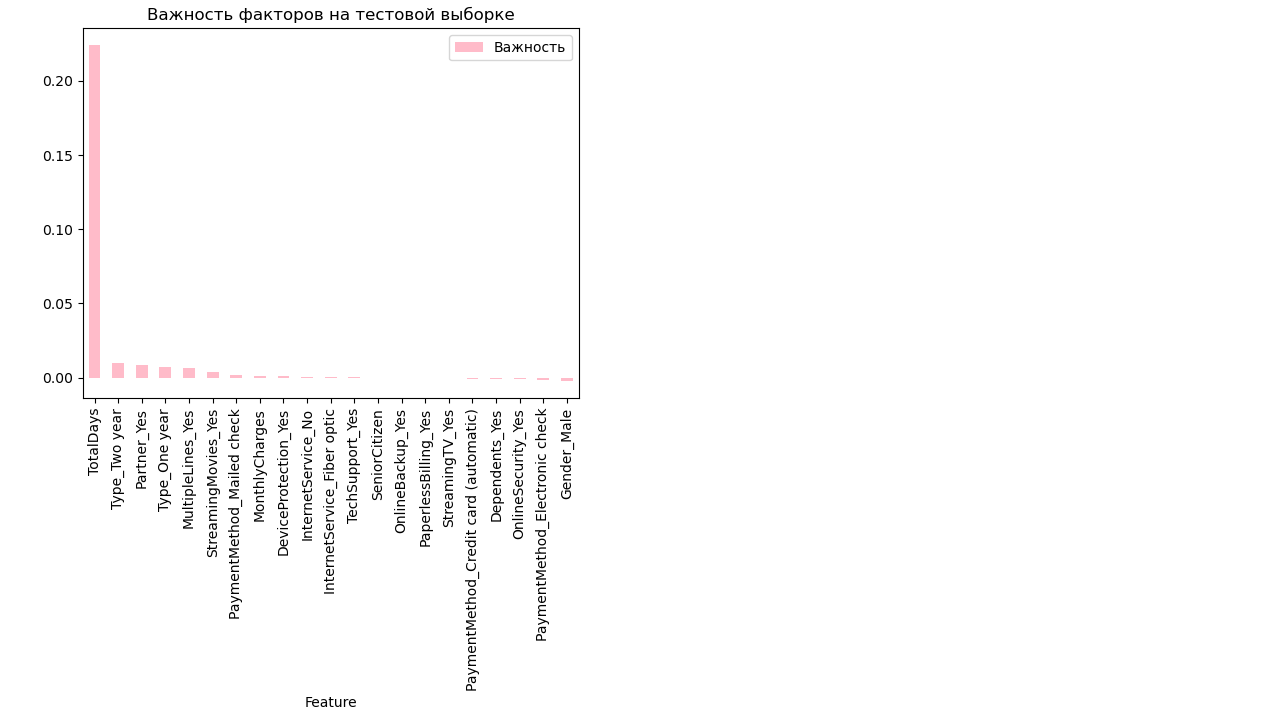


Во время анализа была также получена матрица ошибок, по которой можно заметить, что модель часто верно предсказывает, что клиент не ушёл.

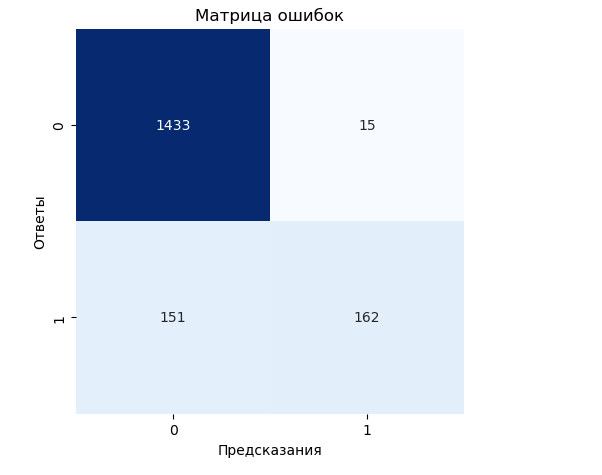

В итоге цель задания была достигнута: модель показала результат выше заданного и может быть применена для определения потенциально уходящих пользователей.

Все пункты плана, изложенного в начале, были выполнены. Главной трудностью стал выбор признаков для обучения модели: некоторые признаки не подходили для обучения (BeginDate, EndDateб TotalCharges, CategoryID), некоторые пришлось создавать самостоятельно (TotalDays, Left). 